In [4]:
import librosa as li
import os
from glob import glob
import json
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch.nn as nn

In [5]:
device = torch.device('cuda')

In [6]:
top_path = "data/nsynth-test"
files = glob(f'{os.path.abspath(top_path)}/**/*.wav', recursive=True)
filenames = [os.path.basename(f).removesuffix('.wav') for f in files]
with open(os.path.join(top_path, 'examples.json')) as f:
    meta = json.load(f)

In [7]:
minpitch,maxpitch = 24,96
filenames = list(filter(lambda f: minpitch <= meta[f]['pitch'] <= maxpitch, filenames))
files = list(map(lambda x : f'{os.path.abspath(top_path)}/audio/{x}.wav',filenames))

filenames = list(filter(lambda f: meta[f]['instrument_source_str'] in ['acoustic'], filenames))
files = list(map(lambda x : f'{os.path.abspath(top_path)}/audio/{x}.wav',filenames))  

filenames = list(filenames)
files = list(files)
print(len(filenames))
print(len(files))

1514
1514


In [8]:
class func2module(nn.Module):
    def __init__(self,f):
        super(func2module,self).__init__()
        self.f = f
    def forward(self,x):
        return self.f(x)

In [9]:
import torchaudio.transforms as T
import torch.nn as nn
nfft = 1024
transform = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000,hop_length= nfft//4,n_mels=128,n_fft=nfft,norm='slaney'),
).to(device)
inverse_transform = nn.Sequential(
    T.InverseMelScale(sample_rate=16000,n_mels=128,n_stft=nfft // 2 + 1,norm="slaney"),
    T.GriffinLim(n_fft=nfft, hop_length=nfft//4),
).to(device)

In [10]:
def getitem(idx: int, load_audio = True) -> tuple[torch.Tensor, float, str]:
    fname = files[idx]
    _fname = filenames[idx]
    if load_audio:
        (2**15)/16000
        audio, _ = li.load(fname, sr=16000, mono=True, duration=2.0)
        audio = torch.from_numpy(audio).to(device)
        x = transform(audio)
    else: 
        x = None
        audio = None
    pitch = meta[_fname]['pitch']
    return {"x": x, "pitch": pitch, "fname": _fname, "audio" : audio}

torch.Size([128, 128])


torch.Size([32000]) torch.Size([32512])


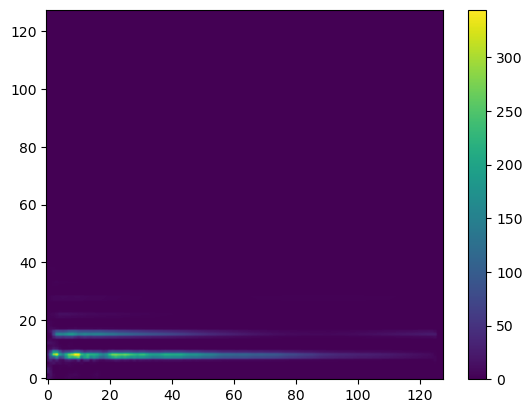

In [11]:
found = 4
for i in range(0):
    item = getitem(i,load_audio=False)
    if item['fname'] == 'bass_synthetic_134-022-100':
        found = i
        print(found)
        break
item = getitem(found)
spec, pitch, fname, audio = item['x'],item['pitch'],item['fname'],item['audio']
spec = nn.functional.pad(spec, (0, 2))
recreated_audio = inverse_transform(spec)
print(spec.shape)
display(Audio(audio.cpu(),rate=16000))
display(Audio(recreated_audio.cpu(),rate=16000))
print(audio.shape, recreated_audio.shape)
plt.imshow(spec.cpu(),origin="lower",aspect='auto')
plt.colorbar()
plt.show()

In [12]:
spec = torch.stack([spec,spec,spec])

In [85]:
label = torch.tensor([2,3,1]).long()
y = nn.functional.one_hot(label.long(),num_classes=70)
print(y.shape)
torch.stack([y.T]*100,dim=0).shape

torch.Size([3, 70])


torch.Size([100, 70, 3])

In [13]:
print(spec.shape)
enc1=nn.Conv1d(in_channels=128,out_channels=512,kernel_size=3,stride=2,padding=1,device=device)(spec)
print(enc1.shape)
enc2=nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1,device=device)(enc1)
print(enc2.shape)
enc3=nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1,device=device)(enc2)
print(enc3.shape)


torch.Size([3, 128, 128])
torch.Size([3, 512, 64])
torch.Size([3, 512, 32])
torch.Size([3, 512, 16])


In [53]:
mu=nn.Conv1d(in_channels=512,out_channels=100,kernel_size=3,padding="same",device=device)(enc3)
print(mu.shape)

torch.Size([3, 100, 16])


In [51]:
decoder = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,padding="same")).to(device)

print(enc3.shape)
dec1 = decoder(enc3)
print(dec1.shape)
dec2 = decoder(enc2)
print(dec2.shape)
dec3 = decoder(enc1)
print(dec3.shape)
nn.Conv1d(512,512,kernel_size=3,padding='same',device=device)(dec3).shape

torch.Size([3, 512, 16])
torch.Size([3, 512, 32])
torch.Size([3, 512, 64])
torch.Size([3, 512, 128])


torch.Size([3, 512, 128])

In [50]:
print(enc3.shape)
dec1 = nn.ConvTranspose1d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1,output_padding=0, device=device)(enc3)
print(dec1.shape)
dec2 = nn.ConvTranspose1d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1,output_padding=0,device=device)(enc2)
print(dec2.shape)
dec3 = nn.ConvTranspose1d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1,output_padding=0,device=device)(enc1)
print(dec3.shape)
nn.Conv1d(512,512,kernel_size=3,padding='same',device=device)(dec3).shape

torch.Size([3, 512, 16])
torch.Size([3, 512, 31])
torch.Size([3, 512, 63])
torch.Size([3, 512, 127])


torch.Size([3, 512, 127])

In [11]:
import numpy as np

In [12]:
from PIL import Image
from torchvision import transforms as vT
img = Image.open("individualImage.png")
img = vT.ToTensor()(img)[0]
plt.imshow(img,aspect='auto',origin='lower')
plt.colorbar()
plt.show()
img = img.to(device)
created_spectro = T.InverseMelScale(sample_rate=16000,n_mels=128,n_stft=1024 // 2 + 1,norm="slaney").to(device)(img)
created_audio=li.griffinlim(created_spectro.cpu().numpy(),n_fft=1024,hop_length=1024//4)
plt.plot(created_audio)
plt.show()
display(Audio(created_audio,rate=16000))


r_audio = inverse_transform(img).cpu()

display(Audio(r_audio,rate=16000))


FileNotFoundError: [Errno 2] No such file or directory: 'individualImage.png'

In [13]:
from datetime import datetime
def find_most_recent_VAE():
    found_files = []
    for _, _, files in os.walk("results"):
        for file in files:
            if len(file)>4 and file[:4] == "VAE_":
                strdate = file[4:]
                date_object = datetime.strptime(strdate,"%d-%m-%Y_%H_%M")
                found_files.append(date_object)
    if found_files:
        found_date = (sorted(found_files)[-1]).strftime("%d-%m-%Y_%H_%M")
        most_recent_file = "VAE_"+found_date
        return most_recent_file
    else:
        raise Exception("No model found")

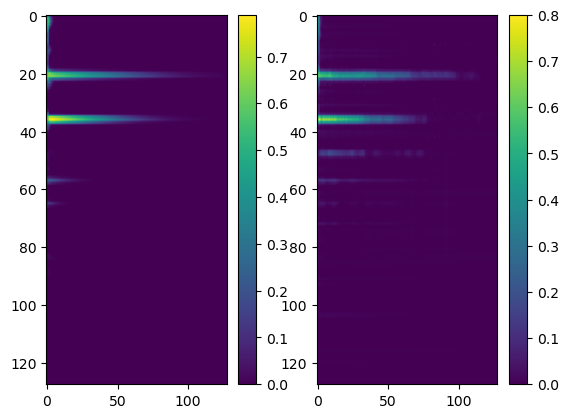

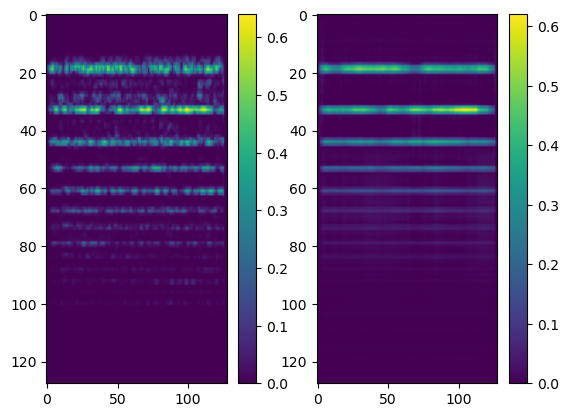

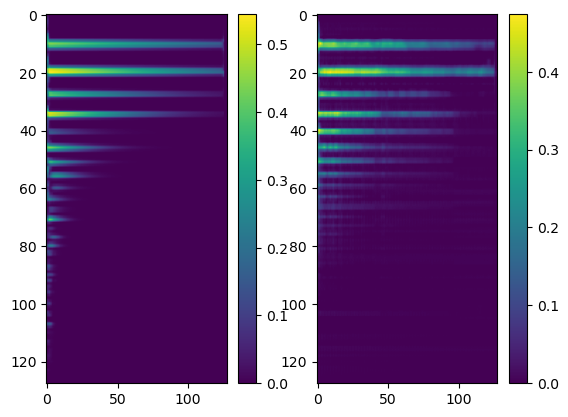

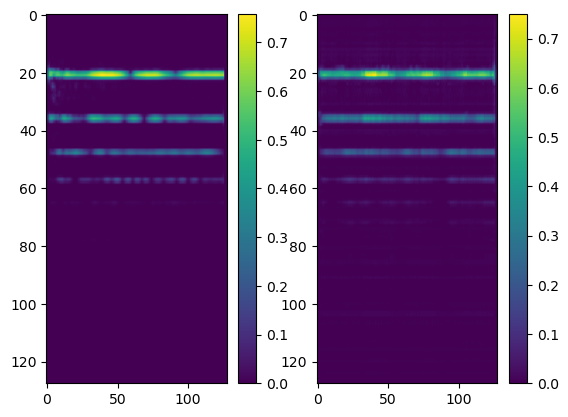

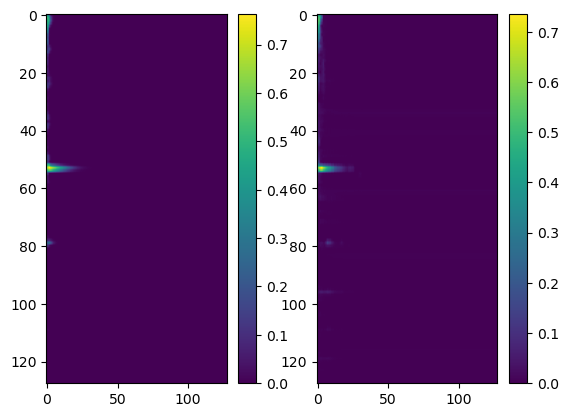

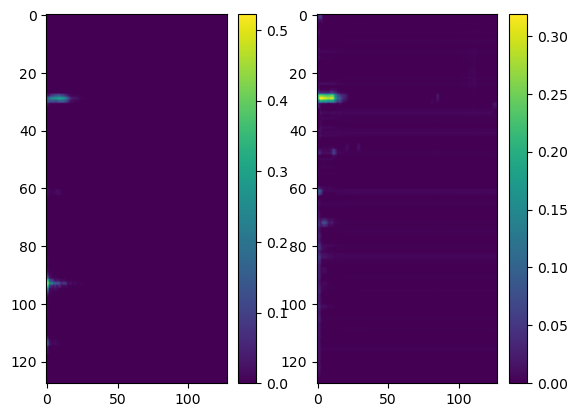

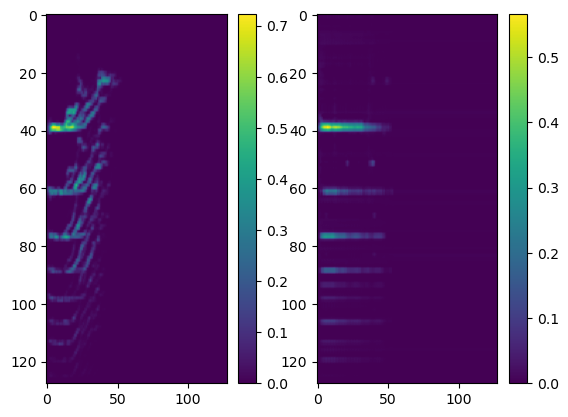

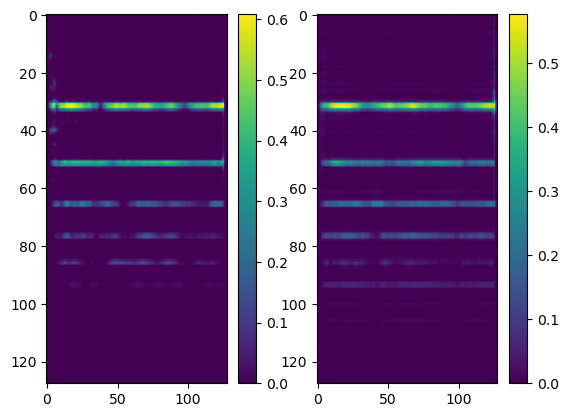

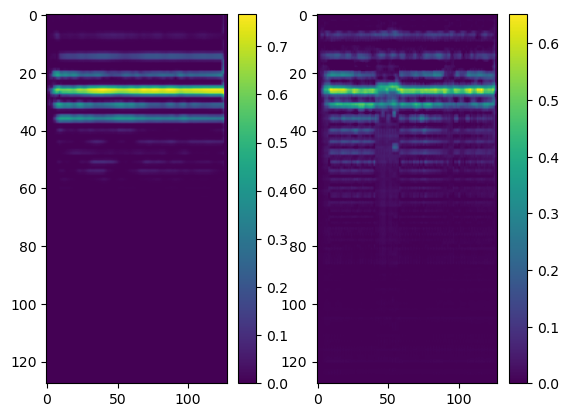

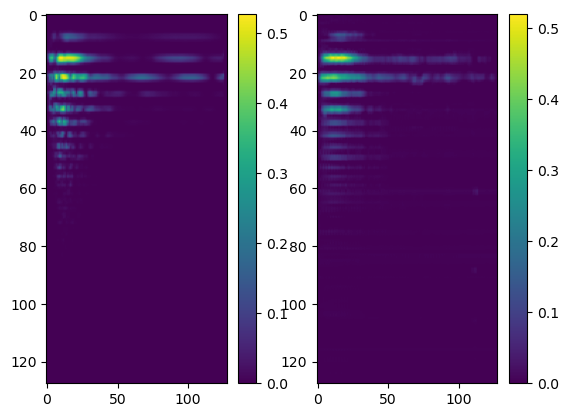

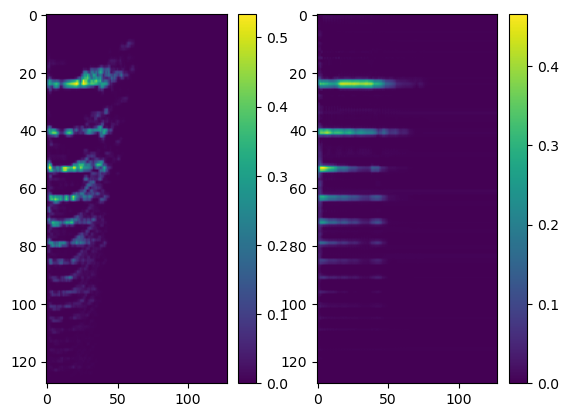

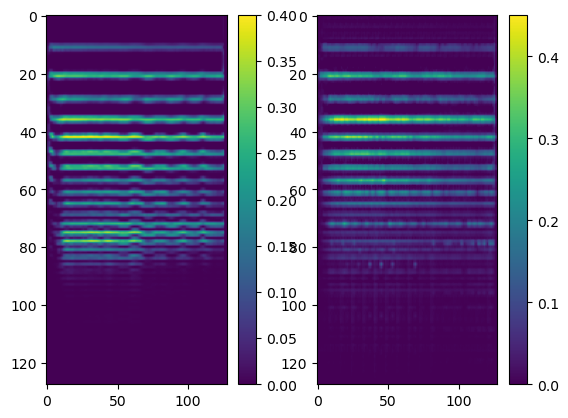

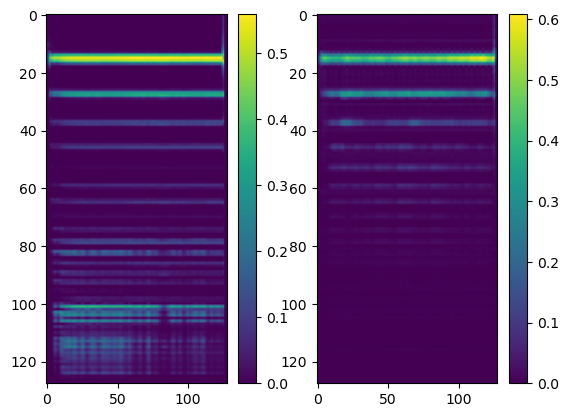

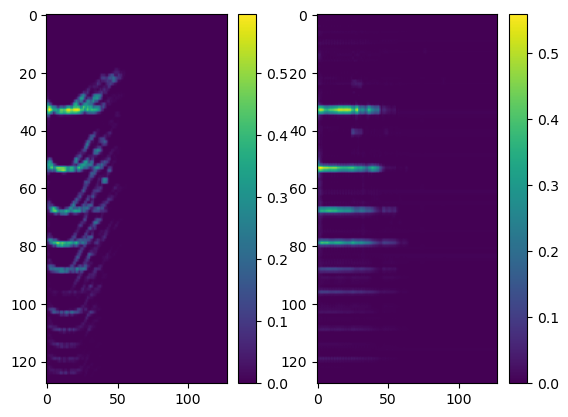

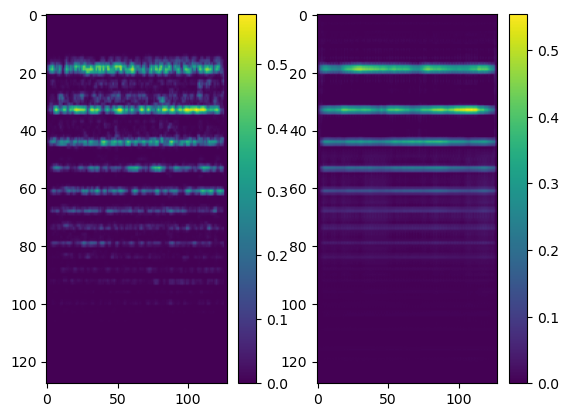

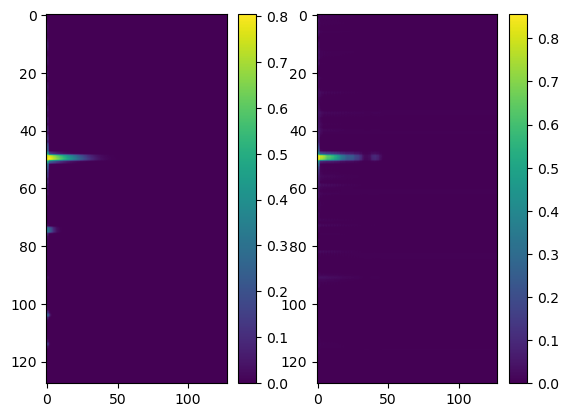

In [14]:
original = torch.load('original_spec_tensor')
generated = torch.load('generated_spec_tensor')
for i in range(16):
    plt.subplot(121)
    plt.imshow(original.cpu()[i],aspect='auto')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(generated.cpu()[i],aspect='auto',vmin=0)
    plt.colorbar()
    plt.show()


In [15]:
minval = torch.load("min_test")
maxval  = torch.load("max_test")

norm = func2module(lambda x: (x - minval) / (maxval - minval))
denorm = func2module(lambda x: x * (maxval - minval) + minval)


In [16]:
inverse_transform = nn.Sequential(
    func2module(denorm),
    func2module(torch.expm1),
    T.InverseMelScale(sample_rate=16000,n_mels=128,n_stft=nfft // 2 + 1,norm="slaney"),
    T.GriffinLim(n_fft=nfft, hop_length=nfft//4),
).to(device)

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [21]:
#model = torch.load('results/'+find_most_recent_VAE())
model = torch.load('results/VAE_14-01-2024_22_38_08')

In [22]:
def interp(x1,x2,n_step):
    z1 = model.encode(x1)[0]
    z2 = model.encode(x2)[0]
    return torch.stack([model.decode(i/n_step * z2 + (n_step-i)/n_step * z1)[0] for i in range(n_step+1)])

In [25]:
item1 = getitem(np.random.randint(1514))
spec1= item1['x']
spec1 = nn.functional.pad(spec1, (0, 2))
spec1 = norm(torch.log1p(spec1))
original_audio1 = inverse_transform(spec1)

item2 = getitem(np.random.randint(1514))
spec2 = item2['x']
spec2 = nn.functional.pad(spec2, (0, 2))
spec2 = norm(torch.log1p(spec2))
original_audio2 = inverse_transform(spec2)

display(Audio(original_audio1.cpu(),rate=16000))
display(Audio(original_audio2.cpu(),rate=16000))

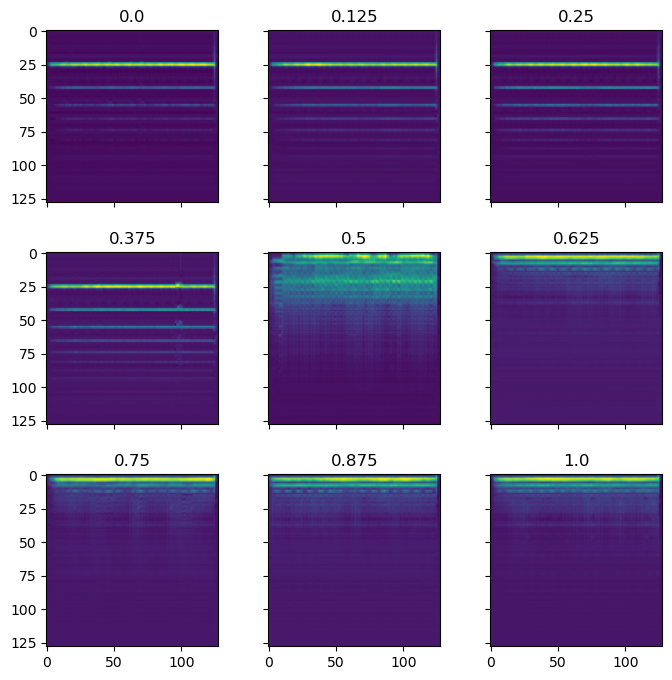

In [26]:
with torch.no_grad():
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                    axes_pad=0.5,  # pad between axes in inch.
                    )
    interp_spec = interp(spec1,spec2,8)
    generated_interp = model(interp_spec)[0]
    generated_audio_interp = inverse_transform(generated_interp)
    audio_cat = torch.tensor([],device=device)
    for i,z in enumerate(zip(grid,generated_interp,generated_audio_interp)):
        ax,generated,generated_audio = z
        ax.imshow(generated.cpu())
        audio_cat=torch.cat([audio_cat,generated_audio])
        ax.set_title(f'{i/8}')
    plt.show()
    display(Audio(generated_audio_interp[0].cpu(),rate=16000))
    display(Audio(audio_cat.cpu(),rate=16000))
    display(Audio(generated_audio_interp[-1].cpu(),rate=16000))

    # generated1 = model(spec1[None,:,:])[0][0]
    # generated_audio1 = inverse_transform(generated1)

    # generated2 = model(spec2[None,:,:])[0][0]
    # generated_audio2 = inverse_transform(generated2)

    # display(Audio(generated_audio1.cpu(),rate=16000))
    # display(Audio(original_audio1.cpu(),rate=16000))
    # display(Audio(generated_audio2.cpu(),rate=16000))
    # display(Audio(original_audio2.cpu(),rate=16000))
    # for ax, im in zip(grid, [generated1.cpu(), spec1.cpu(),generated2.cpu(), spec2.cpu()]):
    #     # Iterating over the grid returns the Axes.
    #     image = ax.imshow(im,cmap='grey')
    # plt.show()

In [34]:
for i,p in enumerate(model.parameters()):
    if p.requires_grad:
        pass
print(i)

32


In [29]:

norms = torch.stack([torch.norm(p.grad.detach(), p=2.0) for p in model.parameters() if p.requires_grad])
print("grad_norm/norm", norms.norm(2.0))
print("grad_norm/mean", norms.mean())

AttributeError: 'NoneType' object has no attribute 'detach'